In [1]:
import numpy as np
import scipy.fft as fft
import matplotlib.pyplot as plt
from scipy.linalg import matmul_toeplitz

from ppfft.tools.grids import domain
from ppfft.tools.phantom_generator import generate_phantom

# Forward PPFFT

We work with an image $I$ of size $n \times n$ where $n$ is even. We try this new definition of the PPFFT for the basically horizontal lines:
$$
\forall (k, l) \in \llbracket 0, n/2 \rrbracket \times \llbracket -n/2, n/2 \rrbracket, \widehat{I}_h (k, l) = \sum_{u=0}^{n-1} \sum_{v=0}^{n-1} I(u, v) \exp\left(-2i\pi \frac{-\frac{2lk}{n}u + kv}{n + 1} \right)
$$

We can rewrite it:
$$
\begin{align*}
\widehat{I}_h (k, l) = \sum_{u=0}^{n-1} \left[ \sum_{v=0}^{n-1} I(u, v) \exp\left(-2i\pi \frac{kv}{n+1} \right) \right] \exp\left(-2i\pi \frac{-2lku}{n(n+1)}\right)
\end{align*}
$$

## Frac FFT

In [2]:
def fast_frac_fft(x: np.ndarray, beta: float, m=None) -> np.ndarray:
    n = len(x)
    w = np.exp(-2j * np.pi * beta)
    dom_in = np.arange(n)
    # Output size is the same as input.
    if m is None:
        dom_out = domain(n)
    # Output size given by m.
    else:
        dom_out = domain(m)
    w_powers_in = w ** (0.5 * dom_in**2)
    w_powers_out = w ** (0.5 * dom_out**2)
    c = w ** (-0.5 * (dom_out - dom_in[0]) ** 2)
    r = w ** (-0.5 * (dom_in - dom_out[0]) ** 2)
    return w_powers_out * matmul_toeplitz((c, r), w_powers_in * x)

In [3]:
def true_frac(x, beta, m=None):
    n = len(x)
    u = np.arange(n)
    if m is None:
        k = domain(n)
    else:
        k = domain(m)
    aux = np.exp(-2j * np.pi * u[:, None] * k[None, :] * beta)
    return np.einsum("u,uk->k", x, aux)

In [4]:
n = 10
x = np.random.rand(n)
beta = np.random.rand()

fast_frac_fft(x, beta, 12) - true_frac(x, beta, 12)

array([ 2.89768209e-14+1.35585987e-14j,  1.40998324e-14-1.34336986e-14j,
        3.66373598e-15+1.11022302e-16j, -5.77315973e-15+1.78745907e-14j,
        4.88498131e-15+1.33226763e-15j,  2.83106871e-14-1.06581410e-14j,
       -8.88178420e-16+2.53765263e-16j, -2.26485497e-14+2.22044605e-16j,
       -1.55431223e-15-5.32907052e-15j,  2.13162821e-14+3.55271368e-15j,
        1.11022302e-15+1.12132525e-14j, -6.66133815e-15+1.49880108e-15j])

## New horizontal PPFFT

In [5]:
def ppfft_horizontal(a: np.ndarray) -> np.ndarray:
    n, _ = a.shape

    res = np.empty((1 + n // 2, n + 1), dtype=complex)

    # 1D FFT of each zero-padded line. Shape = (n, n + 1)
    fft_col = fft.fft(a, n=n+1, axis=-1)[:, :1 + n // 2]
    # Frac FFT on each col
    for k, col in enumerate(fft_col.T):
        res[k, :] = fast_frac_fft(col, beta= -2 * k / (n * (n + 1)), m=n+1)
    return res

In [6]:
def slow_DTFT(a, omega_u, omega_v, m):
    n, _ = a.shape
    u = np.arange(n)
    v = np.arange(n)
    return np.einsum("uv,u,v->", a, np.exp(-2j * np.pi * omega_u * u / m), np.exp(-2j * np.pi * omega_v * v / m))

In [7]:
n = 100
a = np.random.rand(n, n)
hori_ppfft = ppfft_horizontal(a)

In [8]:
true_hori_ppfft = np.empty(shape=(n // 2 + 1, n + 1), dtype=complex)

for i_l, l in enumerate(domain(n + 1)):
    for i_k, k in enumerate(np.arange(0, n//2 + 1)):
        true_hori_ppfft[i_k, i_l] = slow_DTFT(a, -2 * l * k / n, k, n + 1)

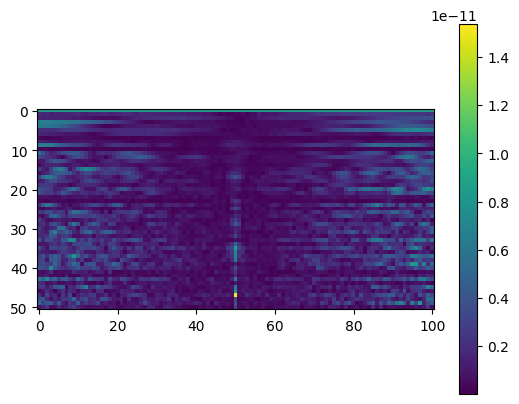

In [9]:
plt.imshow(np.abs(hori_ppfft - true_hori_ppfft))
plt.colorbar()

## New vertical PPFFT

In [10]:
def ppfft_vertical(a):
    return ppfft_horizontal(a.T)

In [11]:
vert_ppfft = ppfft_vertical(a)

In [12]:
true_vert_ppfft = np.empty(shape=(n // 2 + 1, n + 1), dtype=complex)

for i_l, l in enumerate(domain(n + 1)):
    for i_k, k in enumerate((np.arange(0, n//2 + 1))):
        true_vert_ppfft[i_k, i_l] = slow_DTFT(a, k, -2 * l * k / n, n + 1)

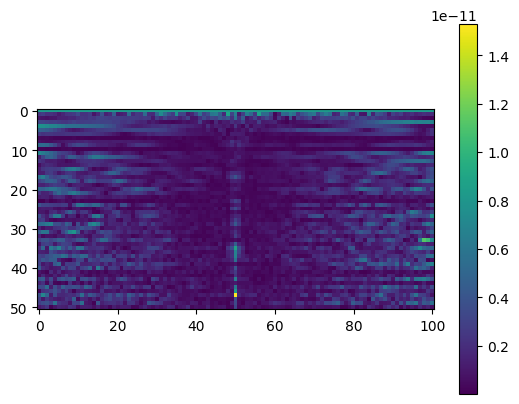

In [13]:
plt.imshow(np.abs(vert_ppfft - true_vert_ppfft))
plt.colorbar()

# New resampling

Convention:
$$
P_\alpha(x) = \sum_{u=0}^{n-1} \alpha(u) \exp(iux)
$$

In [14]:
from scipy.linalg import toeplitz
from ppfft.resampling.inverse_toeplitz import InverseToeplitz
from pynufft import NUFFT
from ppfft.inverse.fast_onion_peeling import new_find_closest

[ 0.08541647-1.67279487e-03j  0.50763551+2.24661073e-01j
 -0.56358895+2.48086278e-01j -0.60735643+1.40264348e+00j
 -0.31371996+1.83341605e+00j  4.68797361+0.00000000e+00j
 -0.31371996-1.83341605e+00j -0.60735643-1.40264348e+00j
 -0.56358895-2.48086278e-01j  0.50763551-2.24661073e-01j
  0.08541647+1.67279487e-03j]
4.755534445025903
[0.25466702 0.47746187 0.65833657 0.79352256 0.63239043 0.46813049
 0.19596837 0.10611998 0.59094863 0.51043016]
[0.25466719 0.47746163 0.65833574 0.79352199 0.63239029 0.46813041
 0.19596808 0.10611963 0.59094833 0.51043031]
8.330262200040295e-07


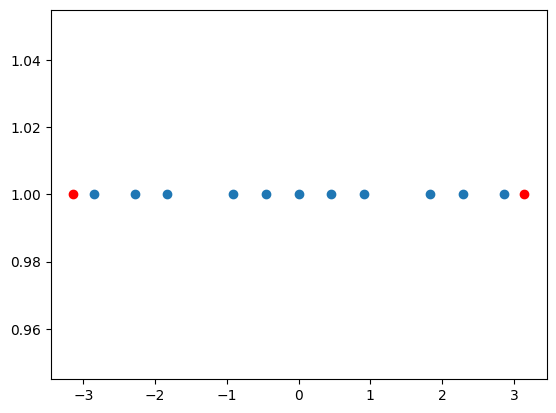

In [15]:
def trigo_poly(alpha, x):
    n = len(alpha)
    u = np.arange(n)
    # u = domain(n)
    ux = np.einsum("u,x->ux", u, x)
    return np.einsum("ux,u->x", np.exp(1j * ux), alpha)

n = 10
k = -(n//2) + 1
alpha = np.random.rand(n)
ppfft_pos = 4 * np.pi * np.arange(-(n//2), n//2 + 1) * k / (n * (n + 1))
samples = trigo_poly(alpha, ppfft_pos)

indices = new_find_closest(k, n)
take_ppfft_pos = np.take(ppfft_pos, indices)
take_samples = np.take(samples, indices)

y_pos = -2 * np.pi * np.arange(-(n//2), k) / (n + 1)
y_neg = 2 * np.pi * np.arange(-(n//2), k)[::-1] / (n + 1)

y = np.concatenate((y_pos, take_ppfft_pos, y_neg)) # condition number explodes if we don not add these points
f = trigo_poly(alpha, y)
print(f)
plt.scatter(y, np.ones_like(y))
plt.scatter([-np.pi, np.pi], [1, 1], c='r')

c = np.einsum("lj->l", np.exp(-1j * np.arange(0, n)[:, None] * y[None, :]))
print(np.linalg.cond(toeplitz(c)))
top = InverseToeplitz(col=c)
NufftObj = NUFFT()
NufftObj.plan(om=-y[:, None], Nd=(n,), Kd=(5 * n,), Jd=(6,))
sol = top.apply_inverse(NufftObj.Kd * NufftObj.adjoint(np.exp(-1j * y * (n // 2)) * f))
print(sol.real)
print(alpha)

print(np.max(np.abs(sol.real - alpha)))

## Initializing $\widehat{I}$

Version without `fft.fftshift`, meaning `I_hat = fft.fft2(im, s=(n+1, n+1))`

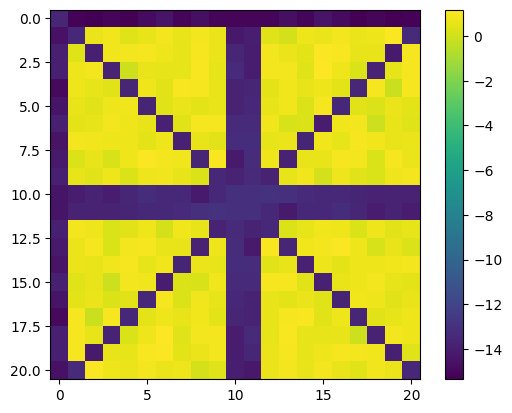

In [16]:
def initialize_I_hat(hori_ppfft, vert_ppfft):
    n = np.shape(hori_ppfft)[1] - 1
    I_hat = np.zeros(shape=(n + 1, n + 1), dtype=complex) # shape (n + 1, n + 1)

    # k = 0
    I_hat[0, n//2 + 1:] = np.conjugate(hori_ppfft[1:, n//2])[::-1]
    I_hat[0, :n//2 + 1] = hori_ppfft[:, n//2]

    # l = 0
    I_hat[n//2 + 1:, 0] = np.conjugate(vert_ppfft[1:, n//2])[::-1]
    I_hat[:n//2 + 1, 0] = vert_ppfft[:, n//2]

    # k = - n//2
    I_hat[n//2 + 1, :] = fft.ifftshift(np.conjugate(vert_ppfft[-1, :]))

    # k = n//2
    I_hat[n//2, :] = fft.ifftshift(vert_ppfft[-1, ::-1])

    # l = - n//2
    I_hat[:, n//2 + 1] = fft.ifftshift(np.conjugate(hori_ppfft[-1, :]))

    # l = n//2
    I_hat[:, n//2] = fft.ifftshift(hori_ppfft[-1, ::-1])

    np.fill_diagonal(I_hat, np.concatenate((hori_ppfft[:, 0], np.conjugate(hori_ppfft[1:, 0])[::-1])))

    np.fill_diagonal(np.fliplr(I_hat)[1:], np.concatenate((vert_ppfft[1:, -1], np.conjugate(vert_ppfft[1:, -1])[::-1])))

    return I_hat

n = 20
a = np.random.rand(n, n)
hori_ppfft = ppfft_horizontal(a)
vert_ppfft = ppfft_vertical(a)
I_hat = initialize_I_hat(hori_ppfft, vert_ppfft)
plt.imshow(np.log10(np.abs(fft.fft2(a, s=(n+1, n+1)) - I_hat)))
plt.colorbar()

In [17]:
def precompute_onion_peeling(n: int, oversampling_factor: int = 5):
    half_n = n // 2
    toeplitz_list = []
    nufft_list = []

    for k in range(half_n - 1, 0, -1):
        y_ppfft = 4 * np.pi * np.arange(-(n//2), n//2 + 1) * k / (n * (n + 1))
        indices = new_find_closest(k, n)
        y_ppfft = np.take(y_ppfft, indices)

        y_pos = -2 * np.pi * np.arange(-(n//2), -k) / (n + 1)
        y_neg = 2 * np.pi * np.arange(-(n//2), -k)[::-1] / (n + 1)

        y = np.concatenate((y_pos, y_ppfft, y_neg))

        c = np.einsum("lj->l", np.exp(-1j * np.arange(0, n)[:, None] * y[None, :]))

        toeplitz_list.append(InverseToeplitz(col=c))

        NufftObj = NUFFT()
        NufftObj.plan(om=-y[:, None], Nd=(n,), Kd=(oversampling_factor * n,), Jd=(6,))
        NufftObj.arr = np.exp(-1j * y * (n // 2))

        nufft_list.append(NufftObj)

    return toeplitz_list, nufft_list

def my_compute_rows(k, I_hat, vert_ppfft_samples, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    0 < k < n//2
    """
    n = np.shape(I_hat)[0] - 1
    # Step: 1, 2, ..., n//2 - 1

    I_hat_pos = I_hat[k, n//2 + 1:n - k + 1]
    I_hat_neg = I_hat[k, k+1:n//2+1]

    known_samples = np.concatenate((I_hat_pos, vert_ppfft_samples, I_hat_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(NufftObj.arr * known_samples))

    res = fft.fft(alpha, n=n+1)

    # Positive row
    I_hat[k, n - k + 2 : n + 1] = res[n - k + 2 : n + 1]
    I_hat[k, 1 : k] = res[1 : k]

    # Negative row
    I_hat[-k, n - k + 2 : n + 1] = np.conjugate(res[1 : k])[::-1]
    I_hat[-k, 1 : k] = np.conjugate(res[n - k + 2 : n + 1])[::-1]

    return alpha


def my_compute_cols(k, I_hat, hori_ppfft_samples, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    0 < k < n//2
    """
    n = np.shape(I_hat)[0] - 1
    # Step: 1, 2, ..., n - 1

    I_hat_pos = I_hat[n//2 + 1:n - k + 1, k]
    I_hat_neg = I_hat[k+1:n//2+1, k]

    known_samples = np.concatenate((I_hat_pos, hori_ppfft_samples, I_hat_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(NufftObj.arr * known_samples))

    res = fft.fft(alpha, n=n+1)

    # Positive row
    I_hat[n - k + 2 : n + 1, k] = res[n - k + 2 : n + 1]
    I_hat[1 : k, k] = res[1 : k]

    # Negative row
    I_hat[n - k + 2 : n + 1, -k] = np.conjugate(res[1 : k])[::-1]
    I_hat[1 : k, -k] = np.conjugate(res[n - k + 2 : n + 1])[::-1]

    return alpha


def my_onion_peeling(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list):
    I_hat = initialize_I_hat(hori_ppfft, vert_ppfft)
    n = hori_ppfft.shape[1] - 1
    for toeplitz_inv, NufftObj, k in zip(toeplitz_list, nufft_list, range(n//2 - 1, 0, -1)):
        indices = new_find_closest(k, n)
        vert_ppfft_samples = np.take(vert_ppfft[k], indices)
        hori_ppfft_samples = np.take(hori_ppfft[k], indices)

        my_compute_rows(k, I_hat, vert_ppfft_samples, toeplitz_inv, NufftObj)
        my_compute_cols(k, I_hat, hori_ppfft_samples, toeplitz_inv, NufftObj)

    return I_hat

In [18]:
n = 100
toeplitz_list, nufft_list = precompute_onion_peeling(n)
a = np.random.rand(n, n)
hori_ppfft, vert_ppfft = ppfft_horizontal(a), ppfft_vertical(a)
res_onion = my_onion_peeling(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list)

/tmp/ipykernel_4750/2228124669.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(res_onion - fft.fft2(a, s=(n+1, n+1)))))


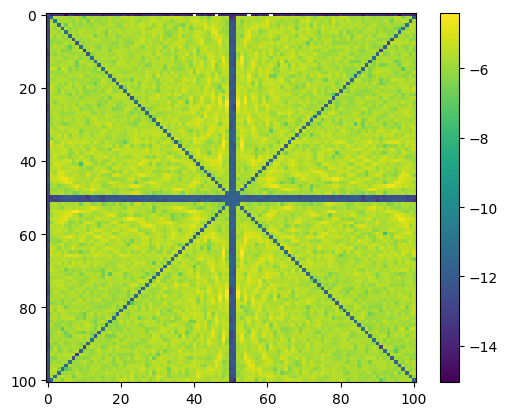

In [19]:
plt.imshow(np.log10(np.abs(res_onion - fft.fft2(a, s=(n+1, n+1)))))
plt.colorbar()

In [20]:
def my_onion_peeling_row(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list):
    I_hat = initialize_I_hat(hori_ppfft, vert_ppfft)
    n = hori_ppfft.shape[1] - 1

    fft_row = np.zeros(shape=(n, n // 2 + 1), dtype=complex)
    fft_row[:, 0] = fft.ifft(I_hat[:, 0])[:-1]
    fft_row[:, -1] = fft.ifft(I_hat[:, n//2])[:-1]

    for toeplitz_inv, NufftObj, k in zip(toeplitz_list, nufft_list, range(n//2 - 1, 0, -1)):
        indices = new_find_closest(k, n)
        vert_ppfft_samples = np.take(vert_ppfft[k], indices)
        hori_ppfft_samples = np.take(hori_ppfft[k], indices)

        my_compute_rows(k, I_hat, vert_ppfft_samples, toeplitz_inv, NufftObj)
        alpha = my_compute_cols(k, I_hat, hori_ppfft_samples, toeplitz_inv, NufftObj)

        fft_row[:, k] = alpha

    return fft_row


def my_direct_inversion(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list):
    fft_row = my_onion_peeling_row(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list)
    return fft.irfft(fft_row, n=n+1)[:, :-1]

In [21]:
n = 1000
toeplitz_list, nufft_list = precompute_onion_peeling(n)

In [22]:
im = generate_phantom(n)
hori_ppfft, vert_ppfft = ppfft_horizontal(im), ppfft_vertical(im)

In [23]:
fft_row = my_onion_peeling_row(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list)

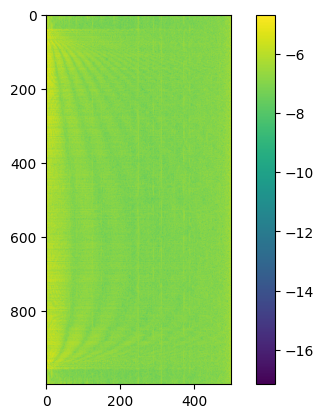

In [24]:
plt.imshow(np.log10(np.abs(fft_row - fft.rfft(im, n=n+1))))
plt.colorbar()

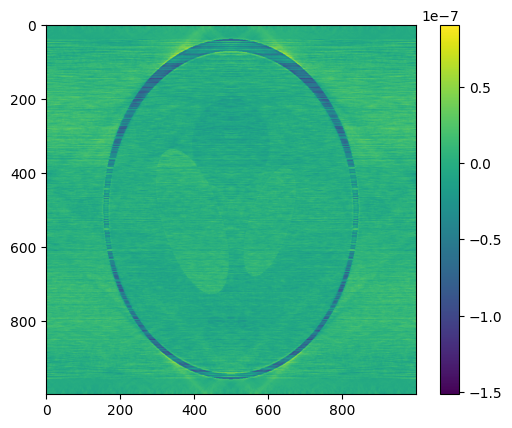

In [25]:
plt.imshow(fft.irfft(fft_row, n=n+1)[:, :-1] - im)
plt.colorbar()

# Interpolation polar $\to$ new pseudopolar

In [26]:
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator

In [27]:
def full_horizontal_grid(n: int) -> np.ndarray:
    dom = domain(n + 1)
    horizontal_x = - 2 * dom[None, :] * dom[:, None] / (n * (n + 1))
    horizontal_y = np.tile(dom[:, None], (1, n + 1)) / (n + 1)
    return horizontal_x, horizontal_y


def full_vertical_grid(n):
    horizontal_x, horizontal_y = full_horizontal_grid(n)
    return horizontal_y, horizontal_x


def half_horizontal_grid(n: int) -> np.ndarray:
    ks = np.arange(0, n // 2 + 1)
    ls = np.arange(- (n // 2), n // 2 + 1)
    horizontal_x = - 2 * ks[:, None] * ls[None, :] / (n * (n + 1))
    horizontal_y = np.tile(ks[:, None], (1, n + 1)) / (n + 1)
    return horizontal_x, horizontal_y


def half_vertical_grid(n):
    horizontal_x, horizontal_y = half_horizontal_grid(n)
    return horizontal_y, horizontal_x


def polar_grid(thetas, n_r):
    """
    n_r should be odd
    """
    rs = domain(n_r) / n_r

    polar_x = np.cos(thetas)[:, None] * rs[None, :]
    polar_y = np.sin(thetas)[:, None] * rs[None, :]

    return polar_x, polar_y

In [28]:
n = 10
old_x, old_y = full_horizontal_grid(n)
new_x, new_y = half_horizontal_grid(n)

print(old_x.shape, old_y.shape)
print(new_x.shape, new_y.shape)

print(old_x[n//2:] - new_x)
print(old_y[n//2:] - new_y)

(11, 11) (11, 11)
(6, 11) (6, 11)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [29]:
n = 10
old_x, old_y = full_vertical_grid(n)
new_x, new_y = half_vertical_grid(n)

print(old_x.shape, old_y.shape)
print(new_x.shape, new_y.shape)

print(old_x[n//2:] - new_x)
print(old_y[n//2:] - new_y)

(11, 11) (11, 11)
(6, 11) (6, 11)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


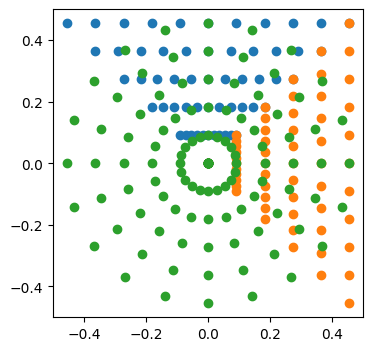

In [30]:
n = 10
hori_x, hori_y = half_horizontal_grid(n)
vert_x, vert_y = half_vertical_grid(n)

angles = np.linspace(0, np.pi, endpoint=False, num=n)
n_r = n + 1
polar_x, polar_y = polar_grid(thetas=angles, n_r=n_r)

fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(np.ravel(hori_x), np.ravel(hori_y))
ax.scatter(np.ravel(vert_x), np.ravel(vert_y))
ax.scatter(np.ravel(polar_x), np.ravel(polar_y))

plt.show()

In [31]:
def polar_fourier_transform(im, thetas, n_r):
    n = len(im)
    rs = domain(n_r) / n_r
    u, v = np.arange(n), np.arange(n)

    cos = -2j * np.pi * np.einsum("k,u,l->kul", rs, u, np.cos(thetas))
    sin = -2j * np.pi * np.einsum("k,v,l->kvl", rs, v, np.sin(thetas))

    res = np.einsum("uv,kul,kvl->lk", im, np.exp(cos), np.exp(sin))

    return res

In [32]:
def direct_2d_interp(polar_ft, polar_x, polar_y, n, interp_fun=CloughTocher2DInterpolator):
    """
    2d interpolation from polar gird to pseudo-polar.

    Parameters
    ----------
    polar_ft : np.ndarray
        Samples of the polar Fourier transform. Shape: (n_theta, n_r).
    x : np.ndarray
        x coordinates of the polar grid. Shape: (n_theta, n_r).
    y : np.ndarray
        y coordinates of the polar grid. Shape: (n_theta, n_r).
    n : int
        Size of the original image.
    interp_fun : class, optional
        2d Interpolator used.

    Returns
    -------
    hori_ppfft : np.ndarray
        Inteprolated horizontal ppfft. Shape: (n+1, n+1).
    vert_ppfft : np.ndarray
        Inteprolated vertical ppfft. Shape: (n+1, n+1).
    """
    points = np.stack((polar_x.flatten(), polar_y.flatten()), axis=-1)
    interpolator = interp_fun(points, polar_ft.flatten(), fill_value=0)

    hori_x, hori_y = half_horizontal_grid(n)

    hori_ppfft = interpolator(hori_x, hori_y)
    vert_ppfft = interpolator(hori_y, hori_x)

    return hori_ppfft, vert_ppfft

In [33]:
n = 200
toeplitz_list, nufft_list = precompute_onion_peeling(n)
im = generate_phantom(n)

In [34]:
angles = np.linspace(0, np.pi, endpoint=False, num=n)
n_r = 4 * n + 1
polar_ft = polar_fourier_transform(im, thetas=angles, n_r=n_r)

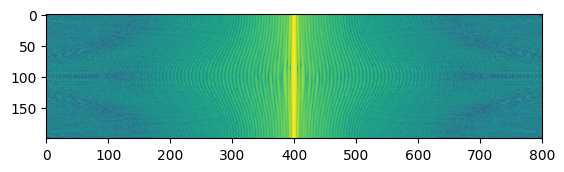

In [35]:
plt.imshow(np.log10(np.abs(polar_ft)))

In [36]:
polar_x, polar_y = polar_grid(angles, n_r=n_r)
hori, vert = direct_2d_interp(polar_ft, polar_x, polar_y, n, LinearNDInterpolator)

In [37]:
true_hori, true_vert = ppfft_horizontal(im), ppfft_vertical(im)

/tmp/ipykernel_4750/1268136349.py:3: RuntimeWarning: divide by zero encountered in log10
  axes[0, 0].imshow(np.log10(np.abs(hori.real)))
/tmp/ipykernel_4750/1268136349.py:6: RuntimeWarning: divide by zero encountered in log10
  axes[0, 1].imshow(np.log10(np.abs(hori.imag)))
/tmp/ipykernel_4750/1268136349.py:7: RuntimeWarning: divide by zero encountered in log10
  axes[1, 1].imshow(np.log10(np.abs(true_hori.imag)))


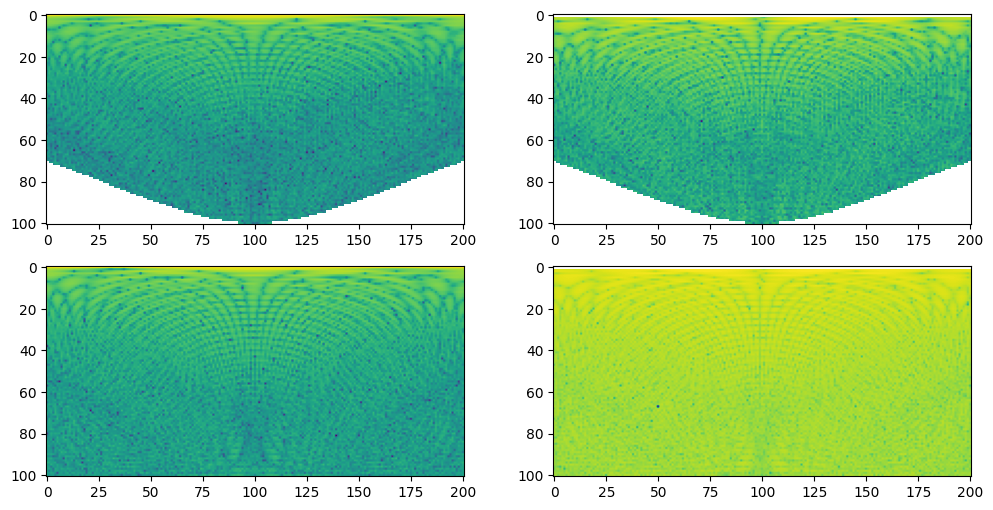

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

axes[0, 0].imshow(np.log10(np.abs(hori.real)))
axes[1, 0].imshow(np.log10(np.abs(true_hori.real)))

axes[0, 1].imshow(np.log10(np.abs(hori.imag)))
axes[1, 1].imshow(np.log10(np.abs(true_hori.imag)))

/tmp/ipykernel_4750/3563550081.py:3: RuntimeWarning: divide by zero encountered in log10
  axes[0, 0].imshow(np.log10(np.abs(vert.real)))
/tmp/ipykernel_4750/3563550081.py:6: RuntimeWarning: divide by zero encountered in log10
  axes[0, 1].imshow(np.log10(np.abs(vert.imag)))
/tmp/ipykernel_4750/3563550081.py:7: RuntimeWarning: divide by zero encountered in log10
  axes[1, 1].imshow(np.log10(np.abs(true_vert.imag)))


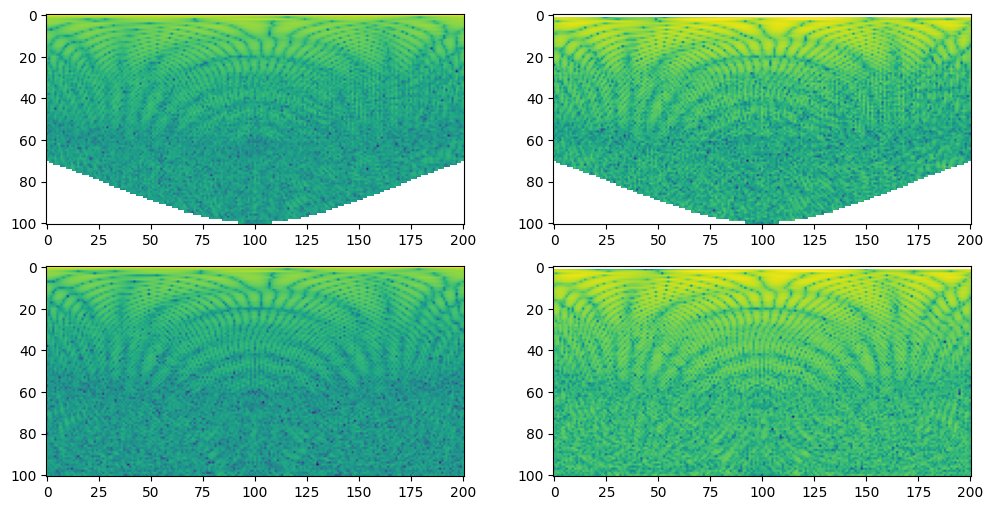

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

axes[0, 0].imshow(np.log10(np.abs(vert.real)))
axes[1, 0].imshow(np.log10(np.abs(true_vert.real)))

axes[0, 1].imshow(np.log10(np.abs(vert.imag)))
axes[1, 1].imshow(np.log10(np.abs(true_vert.imag)))

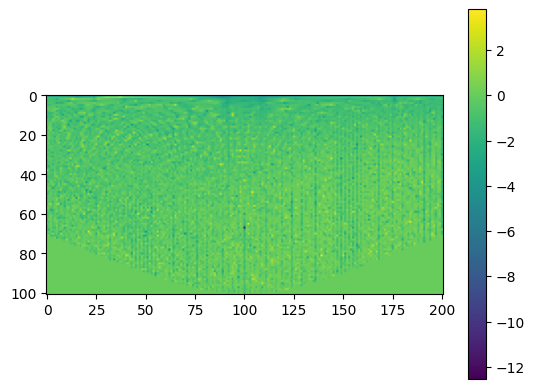

In [40]:
plt.imshow(np.log10(np.abs(hori.real - true_hori.real)) - np.log10(np.abs(true_hori.real)))
plt.colorbar()

/tmp/ipykernel_4750/2045375449.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(hori.imag - true_hori.imag)) - np.log10(np.abs(true_hori.imag)))
/tmp/ipykernel_4750/2045375449.py:1: RuntimeWarning: invalid value encountered in subtract
  plt.imshow(np.log10(np.abs(hori.imag - true_hori.imag)) - np.log10(np.abs(true_hori.imag)))


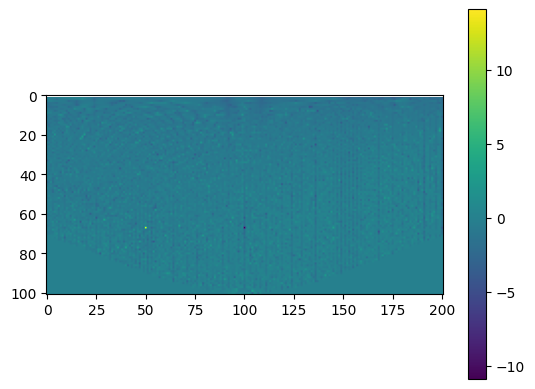

In [41]:
plt.imshow(np.log10(np.abs(hori.imag - true_hori.imag)) - np.log10(np.abs(true_hori.imag)))
plt.colorbar()

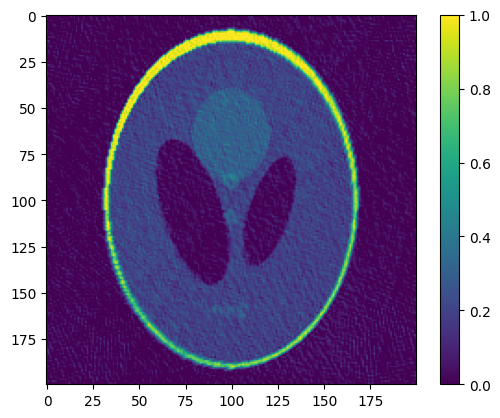

In [42]:
sol = my_direct_inversion(hori, vert, toeplitz_list, nufft_list)
plt.imshow(sol, vmin=0., vmax=1.)
plt.colorbar()

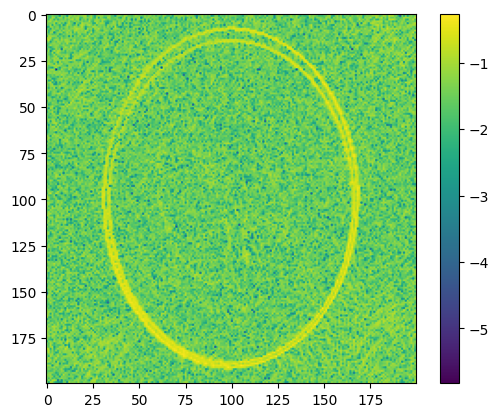

In [61]:
plt.imshow(np.log10(np.abs(sol - im)))
plt.colorbar()

# From sinogram

In [95]:
from silx.image.projection import Projection

from ppfft.tools.new_fft import new_fft
from ppfft.tools.pad import pad

In [97]:
n = 200
toeplitz_list, nufft_list = precompute_onion_peeling(n)

In [98]:
im = generate_phantom(n)

thetas = np.linspace(-np.pi/2, np.pi/2, endpoint=False, num=n)

proj = Projection(im.shape, angles=thetas)
sinogram = proj.projection(im)
pad_sino = np.pad(sinogram, ((0, 0), (0, n))) # zero-padding the sinogram to increase the radial samples
fft_sinogram = fft.fftshift(fft.fft(pad_sino), axes=-1)

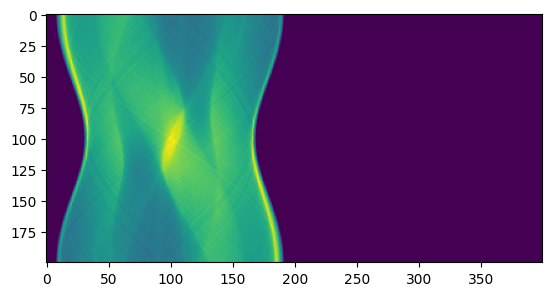

In [99]:
plt.imshow(pad_sino)

In [101]:
polar_ft = polar_fourier_transform(im, thetas=np.pi / 2 + thetas, n_r=2*n)

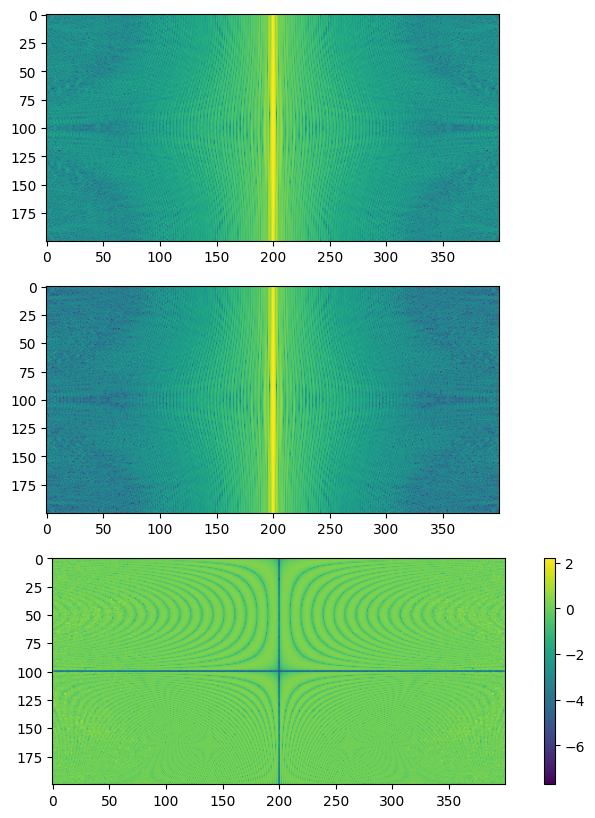

In [103]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

axes[0].imshow(np.log10(np.abs(polar_ft)))
axes[1].imshow(np.log10(np.abs(fft_sinogram)))
c = axes[2].imshow(np.log10(np.abs(polar_ft - fft_sinogram)) - np.log10(np.abs(polar_ft)))
plt.colorbar(c, ax=axes[2])

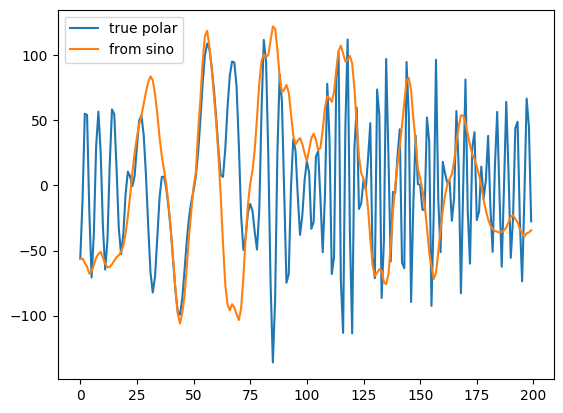

In [105]:
k = 50
plt.plot(polar_ft[:, 200 + k].real, label="true polar")
plt.plot(fft_sinogram[:, 200 + k].real, label="from sino")
plt.legend()

In [106]:
polar_x, polar_y = polar_grid(np.pi / 2 + thetas, 2 * n)
hori_sino, vert_sino = direct_2d_interp(fft_sinogram, polar_x, polar_y, n)
hori_polar, vert_polar = direct_2d_interp(polar_ft, polar_x, polar_y, n)

In [107]:
true_hori, true_vert = ppfft_horizontal(im), ppfft_vertical(im)

/tmp/ipykernel_4750/2086710885.py:3: RuntimeWarning: divide by zero encountered in log10
  axes[0, 0].imshow(np.log10(np.abs(hori_polar.real)))
/tmp/ipykernel_4750/2086710885.py:6: RuntimeWarning: divide by zero encountered in log10
  axes[0, 1].imshow(np.log10(np.abs(hori_polar.imag)))
/tmp/ipykernel_4750/2086710885.py:7: RuntimeWarning: divide by zero encountered in log10
  axes[1, 1].imshow(np.log10(np.abs(true_hori.imag)))


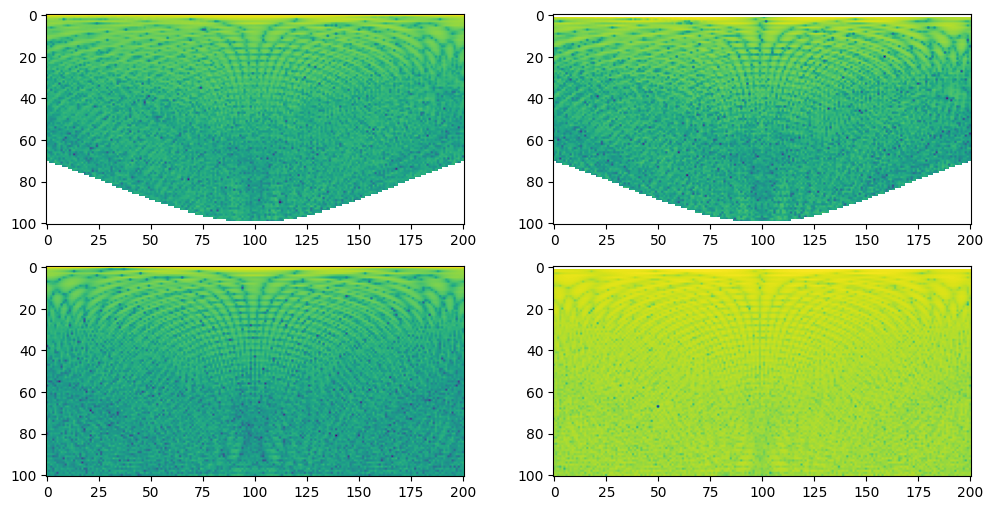

In [108]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

axes[0, 0].imshow(np.log10(np.abs(hori_polar.real)))
axes[1, 0].imshow(np.log10(np.abs(true_hori.real)))

axes[0, 1].imshow(np.log10(np.abs(hori_polar.imag)))
axes[1, 1].imshow(np.log10(np.abs(true_hori.imag)))

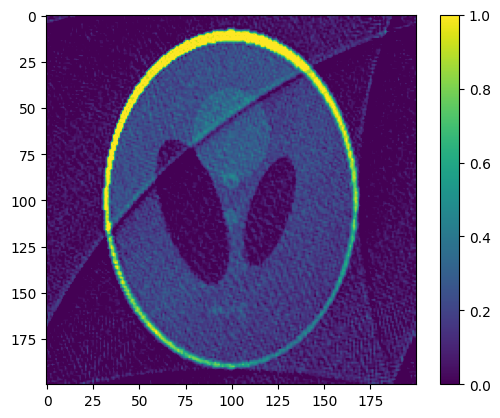

In [109]:
sol = my_direct_inversion(hori_polar, vert_polar, toeplitz_list, nufft_list)
plt.imshow(sol, vmin=0., vmax=1.)
plt.colorbar()

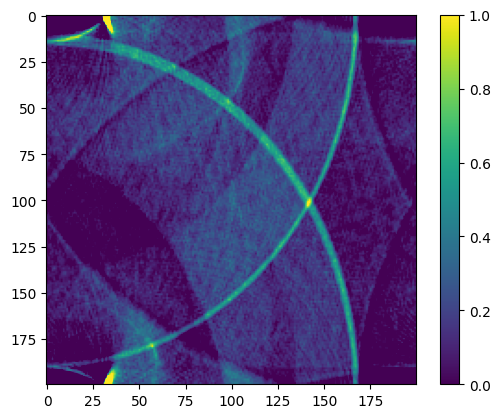

In [110]:
sol = my_direct_inversion(hori_sino, vert_sino, toeplitz_list, nufft_list)
plt.imshow(sol, vmin=0., vmax=1.)
plt.colorbar()